In [2]:
import vibdata.raw as raw_datasets

In [3]:
hust_dataset_name = "HUST"

# Get raw root_dir
hust_raw_root_dir = "../data/raw_data/hust"
hust_raw_dataset = getattr(raw_datasets, hust_dataset_name + "_raw")(hust_raw_root_dir, download=True)

In [4]:
uored_dataset_name = "UORED"

# Get raw root_dir
uored_raw_root_dir = "../data/raw_data/uored"
uored_raw_dataset = getattr(raw_datasets, uored_dataset_name + "_raw")(uored_raw_root_dir, download=True)

In [5]:
pu_dataset_name = "PU"

# Get raw root_dir
pu_raw_root_dir = "../data/raw_data/pu"
pu_raw_dataset = getattr(raw_datasets, pu_dataset_name + "_raw")(pu_raw_root_dir, download=True)

In [6]:
from vibdata.deep.signal.transforms import Transform
import matplotlib.pyplot as plt
from scipy.signal import stft
from vibdata.deep.DeepDataset import convertDataset
from vibdata.deep.signal.transforms import Sequential, Split, Transform
import shutil
import numpy as np
import cv2
import pandas as pd
from scipy.signal import ShortTimeFFT, detrend, stft

class OttawaSpectrogram(Transform):
    """Spectrogram transform

    See `scipy.signal.spectrogram` for more information about the parameters.

    This transformation adds the `delta_t` and `delta_f` columns in metainfo for time
    and frequency resolutions.
    """

    def __init__(
        self,
        window="hann",
        nperseg=None,
        noverlap=None,
        nfft=None,
        detrend="linear",
        return_onesided=True,
        axis=-1,
    ):
        super().__init__()
        self.window = window
        self.nperseg = nperseg
        self.noverlap = noverlap
        self.nfft = nfft
        self.detrend = detrend
        self.return_onesided = return_onesided
        self.axis = axis

    def transform(self, data):
        data = data.copy()
        metainfo = data["metainfo"].copy(deep=True)
        signals = data["signal"]

        ret = []
        new_metainfo = []

        for (_, entry), sig in zip(metainfo.iterrows(), signals):
            sig_sample_rate = entry["sample_rate"]
            detrended_data = detrend(sig)
            f, t, Sxx = stft(
                detrended_data,
                fs=sig_sample_rate,
                window=self.window,
                nperseg=self.nperseg,
                noverlap=self.noverlap,
                nfft=self.nfft,
                detrend=self.detrend,
                return_onesided=self.return_onesided,
                axis=self.axis,
            )

            # Compute the thrshold of the frequency limit
            distances = np.abs(f - 10000)
            max_bound = np.argmin(distances)

            # Get the relevant frequencies of the spectogram and 
            float_mat = np.log(np.abs(Sxx[: max_bound+1, :]**2))
            # Normalize the matrix and convert to a grayscale image
            gray_img = ((float_mat - float_mat.min()) / (float_mat.max() - float_mat.min())) * 255
            gray_img = gray_img.astype(np.uint8)
            # Apply color map and convert to rgb image
            bgr_img = cv2.applyColorMap(gray_img, cv2.COLORMAP_JET)
            rgb_img = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2RGB)
            
            ret.append(rgb_img)
            entry["delta_t"] = t[1] - t[0]
            entry["delta_f"] = f[1] - f[0]
            entry["domain"] = "time-frequency"
            new_metainfo.append(entry)

        data["signal"] = ret
        data["metainfo"] = pd.DataFrame(new_metainfo)
        return data

class Detrend(Transform):

    def __init__(self, field="signal", **kwargs):
        super().__init__()
        self.field = field
        self.kwargs = kwargs

    def transform(self, data):
        data[self.field][0] = detrend(data[self.field][0], **self.kwargs)
        return data

deep_root_dir_hust = "../data/spectograms/HUST_sampled_specs"
deep_root_dir_uored = "../data/spectograms/UORED_sampled_specs"
deep_root_dir_pu = "../data/spectograms/PU_sampled_specs"

transforms_hust = Sequential(
    [   
        Detrend(),
        Split(12800),
        OttawaSpectrogram(window="hann", nperseg=200, noverlap=int(200 * 0.96), nfft=1600)
    ]
)

transforms_uored = Sequential(
    [   
        Detrend(),
        Split(10500),
        OttawaSpectrogram(window="hann", nperseg=180, noverlap=int(180 * 0.96), nfft=1600)
    ]
)

transforms_pu = Sequential(
    [   
        Detrend(),
        Split(16000),
        OttawaSpectrogram(window="hann", nperseg=180, noverlap=int(180 * 0.96), nfft=1600)
    ]
)


[   INFO   ] MusicExtractorSVM: no classifier models were configured by default


In [7]:
deep_dataset_hust = convertDataset(hust_raw_dataset, transforms=transforms_hust, dir_path=deep_root_dir_hust, batch_size=32)
deep_dataset_uored = convertDataset(uored_raw_dataset, transforms=transforms_uored, dir_path=deep_root_dir_uored, batch_size=32)
deep_dataset_pu = convertDataset(pu_raw_dataset, transforms=transforms_pu, dir_path=deep_root_dir_pu, batch_size=32)

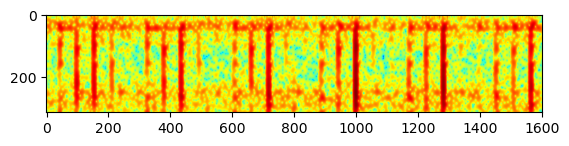

In [8]:
sample = deep_dataset_hust[0]
img = sample["signal"][0]
plt.imshow(img)

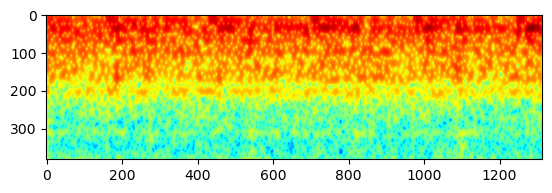

In [ ]:
sample = deep_dataset_uored[0]
img = sample["signal"][0]
plt.imshow(img)

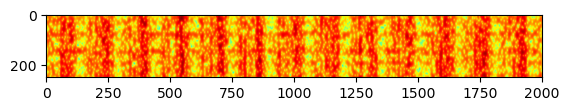

In [10]:
sample = deep_dataset_pu[0]
img = sample["signal"][0]
plt.imshow(img)

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

# Assuming `dataset` is your PyTorch dataset
labels = [item['metainfo']['label'] for item in deep_dataset_pu]

# Count the occurrences of each label
label_counts = Counter(labels)
label_counts

KeyboardInterrupt: 

In [11]:
import torch
all_dataset = [deep_dataset_hust,deep_dataset_uored,deep_dataset_pu]
concat_dataset = torch.utils.data.ConcatDataset(all_dataset)

In [ ]:
import os
import numpy as np
from PIL import Image

# Example dataset and folds (replace with your actual data)

labels_translation = {0:[47,26,40],
                      1:[48,28,41],
                      2:[49,27,42],
                      3:[50,43],
                      4:[51],}

def get_key_from_number(number):
    for key, values in labels_translation.items():
        if number in values:
            return key
    return None

# Define the base directory where you want to save the images
base_dir = '../data/vibnet_images_labels_normalized'

# Create the base directory if it doesn't exist
os.makedirs(base_dir, exist_ok=True)

# Iterate over the dataset and save images in their respective fold folders
for idx, sample in enumerate(concat_dataset):

    label = get_key_from_number(sample['metainfo']['label'])

    if label == None:
        continue

    fold_dir = os.path.join(base_dir, f'img/{label}')
    
    # Create the fold directory if it doesn't exist
    os.makedirs(fold_dir, exist_ok=True)
    
    # Extract the signal (image) from the sample
    signal = sample['signal']
    
    # Remove the first dimension (1, 801, 501, 3) -> (801, 501, 3)
    signal = np.squeeze(signal, axis=0)
    
    # Invert the length (swap height and width) -> (501, 801, 3) -> 
    #signal = np.transpose(signal, (1, 0, 2))
    # Convert the signal array to a PIL image
    if signal.ndim == 3 and signal.shape[2] == 3:  # Check if it's an RGB image
        image = Image.fromarray(signal, 'RGB')
    else:
        raise ValueError("Unsupported signal format. Expected RGB image with shape (H, W, 3).")
    
    # Save the image in the corresponding fold directory
    file_name = f"{idx}.png"  # Change file extension
    save_path = os.path.join(fold_dir, file_name)
    image.save(save_path)
    
    print(f'Saved {save_path}')

print('All images have been saved in their respective fold folders.')

Saved ../data/vibnet_images_labels_normalized/img/1/0.png
Saved ../data/vibnet_images_labels_normalized/img/1/1.png
Saved ../data/vibnet_images_labels_normalized/img/1/2.png
Saved ../data/vibnet_images_labels_normalized/img/1/3.png
Saved ../data/vibnet_images_labels_normalized/img/1/4.png
Saved ../data/vibnet_images_labels_normalized/img/1/5.png
Saved ../data/vibnet_images_labels_normalized/img/1/6.png
Saved ../data/vibnet_images_labels_normalized/img/1/7.png
Saved ../data/vibnet_images_labels_normalized/img/1/8.png
Saved ../data/vibnet_images_labels_normalized/img/1/9.png
Saved ../data/vibnet_images_labels_normalized/img/1/10.png
Saved ../data/vibnet_images_labels_normalized/img/1/11.png
Saved ../data/vibnet_images_labels_normalized/img/1/12.png
Saved ../data/vibnet_images_labels_normalized/img/1/13.png
Saved ../data/vibnet_images_labels_normalized/img/1/14.png
Saved ../data/vibnet_images_labels_normalized/img/1/15.png
Saved ../data/vibnet_images_labels_normalized/img/1/16.png
Saved .